## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics, preprocessing
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt


# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

c:\Users\Jaison\Documents\Workspace\project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Jaison\AppData\Local\Temp\ipykernel_10048\3534039005.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [6]:
data = pd.read_csv("data/ca-dealers-used.csv")


## 3. EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [184]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [187]:
def preliminary_data_cleaning(data):
    # Dropping the id and vin columns
    data = data.drop('id', axis=1)
    data = data.drop('vin', axis=1)
    data = data.drop('stock_no', axis=1)
    
    # Remove duplicate rows
    data = data.drop_duplicates()
    
    # Removing rows with price missing since that is our target column.
    data = data.dropna(subset=['price'])
    # Reset the index of the DataFrame
    data = data.reset_index(drop=True)
    # Shuffle the dataframe
    shuffled_df = data.sample(frac=1, random_state=42)  # Shuffle the dataframe using a random state for reproducibility
    
    return data

In [188]:
# 
def impute_numerical_features(data):
    # Select the numerical features in the DataFrame
    numerical_features = data.select_dtypes(include='number')

    # Create a KNN imputer instance
    #imputer = KNNImputer(n_neighbors=5)

    # Fit the imputer on the numerical features
    #imputer.fit(numerical_features)

    with open('knn_imputer.pkl', 'rb') as file:
        imputer = pickle.load(file)

    #Apply the imputer to the numerical features
    imputed_data = imputer.transform(numerical_features)

    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numerical_features.columns)

    # Replace the original numerical features in the data with the imputed values
    data[numerical_features.columns] = imputed_df
    # Save the imputer to a pickle file
    with open('knn_imputer.pkl', 'wb') as file:
        pickle.dump(imputer, file)
    
    return data

In [189]:
def train_test_splitting(data,split_ratio):
    # Divide the data into training and testing sets
    train_df, test_df = train_test_split(data, test_size=split_ratio, random_state=42)  # Split the shuffled dataframe into training and testing sets
    # Drop the index column from the training set
    train_df = train_df.reset_index(drop=True)

    # Drop the index column from the testing set
    test_df = test_df.reset_index(drop=True)
    return train_df,test_df

In [190]:
#
def remove_NaN_from_categorical_features(data):
    categorical_features = data.select_dtypes(include='object').columns.tolist()
    # Replacing NaN values by "NONE"
    for feature in categorical_features:
        data[feature] = data[feature].fillna("NONE")
    
    return data

## Data CLeaning

In [191]:
# Using function
data=preliminary_data_cleaning(data)
train_df,test_df = train_test_splitting(data, 0.2)
X_train =train_df.drop('price', axis=1)
y_train = train_df['price']
X_train=impute_numerical_features(X_train)
X_train=remove_NaN_from_categorical_features(X_train)


In [192]:
    # Save the X_train to a pickle file
    with open('X_train_cleaned.pkl', 'wb') as file:
        pickle.dump(X_train, file)

In [233]:
    with open('X_train_cleaned.pkl', 'rb') as file:
        X_train = pickle.load(file)

## Feature Engineering

In [236]:
def create_new_features(data):
    # Calculate the 'miles_per_year' feature
    data['miles_per_year'] = (data['miles'] / (2023 - data['year'])).round(0)
    # Create the 'model_trim' column
    data['model_trim'] = data['model'] + ' ' + data['trim']
    data['region'] = data['zip'].str[:3]
    data['age'] = (2023 - data['year'])
    return data

In [237]:
def log_transform(df, features):
    # Create a copy of the DataFrame to avoid modifying the original data
    transformed_df = df.copy()
    
    # Perform logarithmic transformation on the specified features
    for feature in features:
        transformed_df[feature] = np.log(transformed_df[feature])
    df[features] = transformed_df[features]
    
    return df

In [238]:
def scaling_features(data,y_train):
    numerical_features = data.select_dtypes(include=np.number).columns.tolist()

    
    # Remove rows containing infinity or extremely large values
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna(subset=numerical_features, how='any')
    
    y_train = y_train.loc[data.index]

    # Scale the numerical features
#    scaler = StandardScaler()
#    scaler.fit(data[numerical_features])
#    
    
    # Save the scaler to a pickle file
#    with open('scaler.pkl', 'wb') as file:
#        pickle.dump(scaler, file)

    # Load the encoder from the pickle file
    with open('scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)  

    scaled_data = scaler.transform(data[numerical_features])
        
    # Create a new DataFrame with the scaled numerical features
    scaled_df = pd.DataFrame(scaled_data, columns=numerical_features)
    data[numerical_features] = scaled_df[numerical_features]
    
    return scaled_df, y_train

In [239]:
def target_encode_regression(X_train, y_train):
    # Initialize a TargetEncoder object
    encoder = ce.TargetEncoder(cols=X_train.select_dtypes(include='object').columns)
    
    # Fit the encoder on the training data
   # encoder.fit(X_train, y_train)
    
    #with open('encoder.pkl', 'wb') as file:
     #   pickle.dump(encoder, file)
    
    # Load the encoder from the pickle file
    with open('encoder.pkl', 'rb') as file:
        encoder = pickle.load(file)    
    
    # Transform the categorical features in the training data
    X_train_encoded = encoder.transform(X_train)
    
    return X_train_encoded

In [15]:

X_train = create_new_features(X_train)
columns_to_transform = ['miles','miles_per_year']
X_train =log_transform(X_train,columns_to_transform) 

columns_to_remove = ['street','seller_name','year','zip','trim']
# Remove columns from the train_df DataFrame
X_train = X_train.drop(columns=columns_to_remove)

categorical_features = data.select_dtypes(include='object').columns.tolist()
X_train_encoded = target_encode_regression(X_train, y_train)

X_train, y_train = scaling_features(X_train_encoded, y_train)


"\nX_train = create_new_features(X_train)\ncolumns_to_transform = ['miles','miles_per_year']\nX_train =log_transform(X_train,columns_to_transform) \n\ncolumns_to_remove = ['street','seller_name','year','zip','trim']\n# Remove columns from the train_df DataFrame\nX_train = X_train.drop(columns=columns_to_remove)\n\ncategorical_features = data.select_dtypes(include='object').columns.tolist()\nX_train_encoded = target_encode_regression(X_train, y_train)\n\nX_train, y_train = scaling_features(X_train_encoded, y_train)\n"

In [241]:
with open('X_train_after_feature_engg.pkl', 'wb') as file:
    pickle.dump(X_train, file)

### Preparing Testing Data

In [246]:
# Data Cleaning
X_test =test_df.drop('price', axis=1)
y_test = test_df['price']
X_test=impute_numerical_features(X_test)
X_test=remove_NaN_from_categorical_features(X_test)

In [247]:

# Feature Enggineering
X_test = create_new_features(X_test)
columns_to_transform = ['miles','miles_per_year']
X_test =log_transform(X_test,columns_to_transform) 

columns_to_remove = ['street','seller_name','year','zip','trim']
# Remove columns from the train_df DataFrame
X_test = X_test.drop(columns=columns_to_remove)

categorical_features = data.select_dtypes(include='object').columns.tolist()
X_test_encoded = target_encode_regression(X_test, y_test)

X_test_scaled,y_test = scaling_features(X_test_encoded,y_test)

In [249]:
X_test = X_test_scaled

with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

In [248]:
with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

#### Load X_train, y_train, X_test, y_test

In [3]:

with open('/kaggle/input/used-car/X_train_after_feature_engg (1).pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('/kaggle/input/used-car/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
with open('/kaggle/input/used-car/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)
with open('/kaggle/input/used-car/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

## Feature Selection

##### Using SelectFromModel and Random Forest

In [251]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model on the training data
rf.fit(X_train, y_train)

# Create a SelectFromModel object with the fitted Random Forest model
feature_selector = SelectFromModel(rf, threshold='median', prefit=True)

# Apply feature selection on the training data
X_train_selected = feature_selector.transform(X_train)

# Get the selected feature indices
selected_feature_indices = feature_selector.get_support(indices=True)

# Subset the test data with the selected features
X_test_selected = X_test.iloc[:, selected_feature_indices]

# Print the selected feature names
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected Features:")
selected_feature_names


Selected Features:


Index(['miles', 'make', 'model', 'body_type', 'engine_size', 'miles_per_year',
       'model_trim', 'age'],
      dtype='object')

In [252]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor()

# Fit the XGBoost model on the training data
xgb_reg.fit(X_train, y_train)

# Get feature importance scores
feature_importance = xgb_reg.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a dictionary of feature names and their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Feature Importance:
model_trim: 0.34526127576828003
make: 0.1800975799560547
model: 0.14517387747764587
age: 0.10516770929098129
miles: 0.06032661721110344
vehicle_type: 0.030753279104828835
engine_size: 0.023577110841870308
fuel_type: 0.018548671156167984
drivetrain: 0.018542617559432983
engine_block: 0.01792254112660885
miles_per_year: 0.013986341655254364
body_type: 0.012852695770561695
state: 0.01008549053221941
region: 0.008487620390951633
transmission: 0.005455797538161278
city: 0.00376075878739357


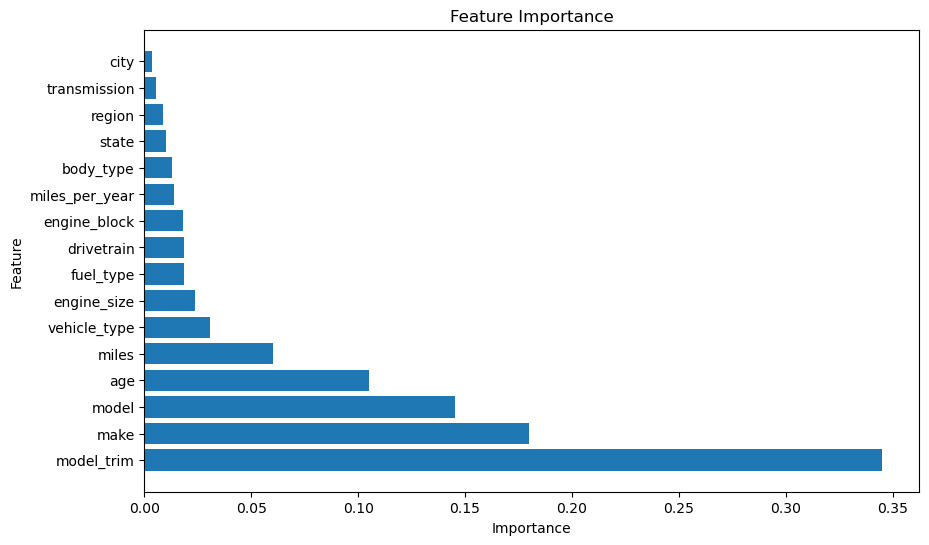

In [253]:

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), [importance for feature, importance in sorted_feature_importance], align='center')
plt.yticks(range(len(feature_importance)), [feature for feature, importance in sorted_feature_importance])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


Feature Importance:
model_trim: 0.47934343290644243
model: 0.19188615896875558
make: 0.09928531878599671
age: 0.0973149386015013
miles: 0.07199575702778967
engine_size: 0.014430605542640442
miles_per_year: 0.011175283692223868
body_type: 0.006167582083254024
region: 0.0057012311851047
drivetrain: 0.005335643524353101
fuel_type: 0.004264142934496366
city: 0.00417851967392627
state: 0.0037044864253621425
vehicle_type: 0.0023390600319577806
engine_block: 0.001813373068240133
transmission: 0.0010644655479555977


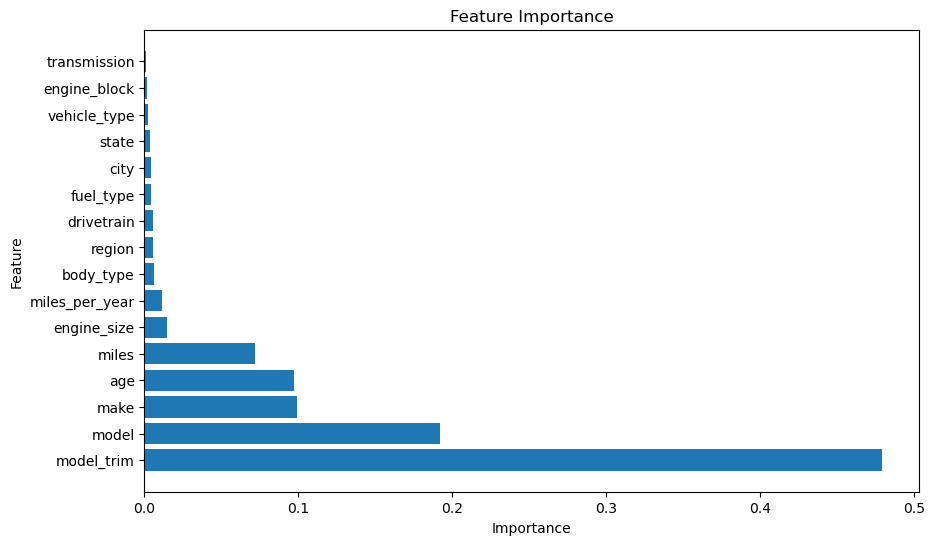

In [255]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Create a Random Forest regressor
rf_reg = RandomForestRegressor()

# Fit the Random Forest model on the training data
rf_reg.fit(X_train, y_train)

# Get feature importance scores
feature_importance = rf_reg.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a dictionary of feature names and their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance in descending order
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), [importance for feature, importance in sorted_feature_importance], align='center')
plt.yticks(range(len(feature_importance)), [feature for feature, importance in sorted_feature_importance])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


In [4]:
selected_features = ['miles', 'make', 'model', 'body_type', 'engine_size', 'miles_per_year',
       'model_trim', 'age', 'vehicle_type', 'fuel_type']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

train, test, target, target_test = X_train, X_test, y_train, y_test

## Tuning models

#### Making functions for model evaluation

In [5]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [6]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [7]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [8]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

#### Models

####  Linear Regression


In [10]:
#####  Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [ 9100.50535063 31232.12117399 33336.93655523 20271.24048022
 32595.44077331]
acc(r2_score) for train = 76.46
acc(relative error) for train = 19.39
acc(rmse) for train = 996697.28
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15948.26775399 42202.33868098 42760.5282571  49609.57433223
 28271.41683742]
acc(r2_score) for test = 73.92
acc(relative error) for test = 19.61
acc(rmse) for test = 1057048.83


In [11]:
with open('linreg.pkl', 'wb') as file:
    pickle.dump(linreg, file)

#### Linear SVR

In [12]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [11602.51364452 28798.53449395 31416.45297803 21901.85008367
 32838.36144728]
acc(r2_score) for train = 68.69
acc(relative error) for train = 16.98
acc(rmse) for train = 1149543.14
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [18777.82068158 41801.02975739 46929.58356562 46508.9583949
 23970.70933689]
acc(r2_score) for test = 65.36
acc(relative error) for test = 17.13
acc(rmse) for test = 1218299.83


In [13]:
with open('linear_svr.pkl', 'wb') as file:
    pickle.dump(linear_svr, file)

#### MLPRegressor

In [9]:
# MLPRegressor

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [2,5,8,10,15],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=5, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13387.98312795 27956.5753146  34653.14739839 22187.3677207
 32998.84732741]
acc(r2_score) for train = 86.15
acc(relative error) for train = 14.33
acc(rmse) for train = 764440.54
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15407.47645376 49474.02584019 56193.74212241 50036.44746612
 25253.44425629]
acc(r2_score) for test = 84.38
acc(relative error) for test = 14.54
acc(rmse) for test = 818055.65


In [10]:
with open('MLPRegressor.pkl', 'wb') as file:
    pickle.dump(mlp_GS, file)

In [ ]:
print("Hello")

#### Stochastic Gradient Descent

In [14]:
# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4,sgd,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [ 9915.20100569 31120.62909973 33623.25539688 21017.51588177
 32721.77531887]
acc(r2_score) for train = 76.11
acc(relative error) for train = 18.4
acc(rmse) for train = 1004022.88
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [16811.54905797 43100.48371739 43510.17219131 48904.2043451
 27750.84222669]
acc(r2_score) for test = 73.41
acc(relative error) for test = 18.63
acc(rmse) for test = 1067471.25


In [15]:
with open('sgd.pkl', 'wb') as file:
    pickle.dump(sgd, file)

#### Decision Tree Regressor

In [16]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13899. 19900. 39995. 22500. 27087.]
acc(r2_score) for train = 99.81
acc(relative error) for train = 0.61
acc(rmse) for train = 88431.12
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [13995.  57998.  60109.  58345.5 25980. ]
acc(r2_score) for test = 89.7
acc(relative error) for test = 6.41
acc(rmse) for test = 664486.74


In [18]:
with open('decision_tree.pkl', 'wb') as file:
    pickle.dump(decision_tree, file)

#### Random Forest 

In [10]:
# Random Forest

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions={'n_estimators': [100, 300]}, cv=5)
random_forest.fit(train, target)
print("Best parameters:", random_forest.best_params_)
acc_model(6, random_forest, train, test)

Best parameters: {'n_estimators': 300}
target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13899.         23101.35       39831.41333333 22782.61
 27109.67      ]
acc(r2_score) for train = 99.42
acc(relative error) for train = 2.43
acc(rmse) for train = 156971.53
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [14279.29       59855.04111111 62592.75083333 58363.68513228
 26313.29833333]
acc(r2_score) for test = 91.58
acc(relative error) for test = 6.04
acc(rmse) for test = 600686.02


In [11]:
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(random_forest, file)

#### XGB

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgbr = xgb.XGBRegressor(objective='reg:squarederror')
parameters = {'n_estimators': [60, 70, 80, 90, 95, 100, 105, 110, 120, 130, 140],
              'learning_rate': [0.005, 0.01, 0.05, 0.075, 0.1],
              'max_depth': [3, 5, 7, 9],
              'reg_lambda': [0.1, 0.3, 0.5]}
xgb_reg = RandomizedSearchCV(estimator=xgbr, param_distributions=parameters, cv=5, n_jobs=-1).fit(train, target)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)


In [27]:
acc_boosting_model(7, xgb_reg, train, test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [12897.827 28114.896 38698.992 21003.424 30038.307]
acc(r2_score) for train = 97.91
acc(relative error) for train = 7.9
acc(rmse) for train = 297163.73
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15281.398 61777.93  62762.75  54678.58  25187.7  ]
acc(r2_score) for test = 91.8
acc(relative error) for test = 8.84
acc(rmse) for test = 592655.22


In [ ]:
with open('xgb_reg.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

#### LGBM

In [ ]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train, test, target, target_test
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=2000,verbose_eval=500, valid_sets=valid_set)

In [28]:
acc_boosting_model(8,modelL,train,test,modelL.best_iteration)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13396.44108682 28431.92614658 38232.62887941 20735.93356374
 29963.19558615]
acc(r2_score) for train = 97.98
acc(relative error) for train = 7.59
acc(rmse) for train = 291789.94
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15420.00845016 59843.99714858 62661.90113758 53779.86280345
 24592.20897941]
acc(r2_score) for test = 93.97
acc(relative error) for test = 8.37
acc(rmse) for test = 508365.22


In [ ]:
with open('LGBM.pkl', 'wb') as file:
    pickle.dump(modelL, file)

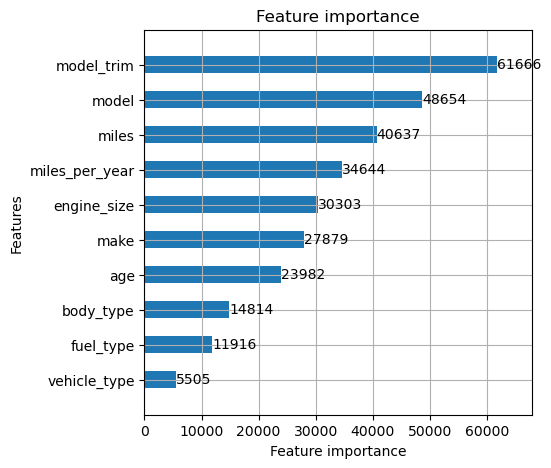

In [38]:
import matplotlib.pyplot as plt
import lightgbm as lgb

fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

#### RidgeRegressor

In [30]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [ 9104.01044119 31234.25273963 33326.34659739 20268.05953029
 32599.13750709]
acc(r2_score) for train = 76.46
acc(relative error) for train = 19.39
acc(rmse) for train = 996697.46
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15951.65291016 42199.32357176 42765.13017512 49608.19748482
 28273.63906278]
acc(r2_score) for test = 73.92
acc(relative error) for test = 19.61
acc(rmse) for test = 1057043.25


In [31]:
with open('ridge.pkl', 'wb') as file:
    pickle.dump(ridge, file)

#### BaggingRegressor

In [32]:
# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(11,bagging,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13899.  24455.9 38744.8 22500.  27087. ]
acc(r2_score) for train = 99.24
acc(relative error) for train = 2.66
acc(rmse) for train = 179385.08
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15669.5        56588.2        60382.8        58929.43333333
 26556.08      ]
acc(r2_score) for test = 91.22
acc(relative error) for test = 6.35
acc(rmse) for test = 613329.07


In [33]:
with open('bagging.pkl', 'wb') as file:
    pickle.dump(bagging, file)

#### ExtraTreesRegressor 

In [34]:
# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(12,etr,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13899. 19900. 39995. 22500. 27087.]
acc(r2_score) for train = 99.81
acc(relative error) for train = 0.61
acc(rmse) for train = 88433.37
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [13995.   57996.99 62610.28 58345.5  26216.6 ]
acc(r2_score) for test = 94.7
acc(relative error) for test = 5.15
acc(rmse) for test = 476339.54


In [35]:
with open('ExtraTreesRegressor.pkl', 'wb') as file:
    pickle.dump(etr, file)

#### AdaBoost Regressor

In [36]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [30306.19804797 34416.51792942 30306.19804797 30306.19804797
 47367.35824529]
acc(r2_score) for train = 29.1
acc(relative error) for train = 54.69
acc(rmse) for train = 1729673.93
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [37242.02275876 47367.35824529 48021.73181367 64295.54217118
 30306.19804797]
acc(r2_score) for test = 28.27
acc(relative error) for test = 55.07
acc(rmse) for test = 1753171.99


In [37]:
with open('Ada_Boost.pkl', 'wb') as file:
    pickle.dump(Ada_Boost, file)

#### VotingRegressor 

In [15]:
# Loading best models for VOting Regressor
with open('/kaggle/input/used-car/linreg.pkl', 'rb') as file:
    linreg = pickle.load(file)
with open('/kaggle/input/used-car/linear_svr.pkl', 'rb') as file:
    linear_svr = pickle.load(file)
with open('/kaggle/input/used-car/MLPRegressor.pkl', 'rb') as file:
    mlp_GS = pickle.load(file)
with open('/kaggle/input/used-car/sgd.pkl', 'rb') as file:
    sgd = pickle.load(file)

with open('/kaggle/input/used-car/decision_tree.pkl', 'rb') as file:
    decision_tree = pickle.load(file)
with open('/kaggle/working/random_forest.pkl', 'rb') as file:
    random_forest = pickle.load(file)
with open('/kaggle/input/used-car/xgb_reg.pkl', 'rb') as file:
    xgb_reg = pickle.load(file)
with open('/kaggle/input/used-car/ExtraTreesRegressor.pkl', 'rb') as file:
    etr = pickle.load(file)

with open('/kaggle/input/used-car/ridge.pkl', 'rb') as file:
    ridge = pickle.load(file)
with open('/kaggle/input/used-car/bagging.pkl', 'rb') as file:
    bagging = pickle.load(file)
with open('/kaggle/input/used-car/LGBM.pkl', 'rb') as file:
    modelL = pickle.load(file)
with open('/kaggle/input/used-car/Ada_Boost.pkl', 'rb') as file:
    Ada_Boost = pickle.load(file)
with open('/kaggle/input/used-car/VotingRegressor2.pkl', 'rb') as file:
    Voting_Reg = pickle.load(file)

acc_model(0,linreg,train,test)
acc_model(1,linear_svr,train,test)
acc_model(2,mlp_GS,train,test)
acc_model(3,sgd,train,test)
acc_model(4,decision_tree,train,test)
acc_model(5, random_forest, train, test)
acc_boosting_model(6, xgb_reg, train, test)
acc_boosting_model(7,modelL,train,test,modelL.best_iteration)
acc_model(8,ridge,train,test)
acc_model(9,bagging,train,test)
acc_model(10,etr,train,test)
acc_model(11,Ada_Boost,train,test)
#acc_boosting_model(12,Voting_Reg,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [ 9100.50535063 31232.12117399 33336.93655523 20271.24048022
 32595.44077331]
acc(r2_score) for train = 76.46
acc(relative error) for train = 19.39
acc(rmse) for train = 996697.28
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [15948.26775399 42202.33868098 42760.5282571  49609.57433223
 28271.41683742]
acc(r2_score) for test = 73.92
acc(relative error) for test = 19.61
acc(rmse) for test = 1057048.83
target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [11602.51364452 28798.53449395 31416.45297803 21901.85008367
 32838.36144728]
acc(r2_score) for train = 68.69
acc(relative error) for train = 16.98
acc(rmse) for train = 1149543.14
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [18777.82068158 41801.02975739 46929.58356562 46508.9583949
 23970.70933689]
acc(r2_score) for test = 65.36
acc(relative error) for test = 17.13
acc(rmse) for test = 1218299.83
target =  [13899. 19900. 39995. 22500. 27087.]
ytrai

In [16]:
Voting_Reg = VotingRegressor(estimators=[('random_forest', random_forest.best_estimator_), ('xgb_reg', xgb_reg.best_estimator_), ('etr', etr)])
Voting_Reg.fit(train, target)
acc_boosting_model(12,Voting_Reg,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13565.27571615 23631.8766059  39495.32739583 22093.89349826
 28070.76888021]
acc(r2_score) for train = 99.45
acc(relative error) for train = 3.51
acc(rmse) for train = 152141.62
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [14590.30614583 60174.49396991 62890.87222222 57068.07574305
 25874.33251736]
acc(r2_score) for test = 93.29
acc(relative error) for test = 6.38
acc(rmse) for test = 536190.73


In [17]:
acc_boosting_model(12,Voting_Reg,train,test)

target =  [13899. 19900. 39995. 22500. 27087.]
ytrain =  [13565.27571615 23631.8766059  39495.32739583 22093.89349826
 28070.76888021]
acc(r2_score) for train = 99.45
acc(relative error) for train = 3.51
acc(rmse) for train = 152141.62
target_test = [13995. 57949. 48886. 47995. 25749.]
ytest = [14590.30614583 60174.49396991 62890.87222222 57068.07574305
 25874.33251736]
acc(r2_score) for test = 93.29
acc(relative error) for test = 6.38
acc(rmse) for test = 536190.73


In [18]:
with open('VotingRegressor2.pkl', 'wb') as file:
    pickle.dump(VotingRegressor, file)

## Models comparison

In [19]:
models = pd.DataFrame({
    'Model': ['Linear Regression',  'Linear SVR', 
              'MLPRegressor', 'Stochastic Gradient Decent', 
              'Decision Tree Regressor', 'Random Forest',  'XGB', 'LGBM',
              'GradientBoostingRegressor', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', 'VotingRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [20]:
pd.options.display.float_format = '{:,.2f}'.format

In [21]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
10,BaggingRegressor,99.81,94.70,0.61,5.15,"88,433.37","476,339.54"
7,LGBM,97.98,93.97,7.59,8.37,"291,789.94","508,365.22"
12,AdaBoostRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
13,VotingRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
6,XGB,97.91,91.80,7.90,8.84,"297,163.73","592,655.22"
5,Random Forest,99.42,91.58,2.43,6.04,"156,971.53","600,686.02"
9,RidgeRegressor,99.24,91.22,2.66,6.35,"179,385.08","613,329.07"
4,Decision Tree Regressor,99.81,89.70,0.61,6.41,"88,431.12","664,486.74"
2,MLPRegressor,86.15,84.38,14.33,14.54,"764,440.54","818,055.65"
0,Linear Regression,76.46,73.92,19.39,19.61,"996,697.28","1,057,048.83"


In [22]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
10,BaggingRegressor,99.81,94.70,0.61,5.15,"88,433.37","476,339.54"
5,Random Forest,99.42,91.58,2.43,6.04,"156,971.53","600,686.02"
9,RidgeRegressor,99.24,91.22,2.66,6.35,"179,385.08","613,329.07"
12,AdaBoostRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
13,VotingRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
4,Decision Tree Regressor,99.81,89.70,0.61,6.41,"88,431.12","664,486.74"
7,LGBM,97.98,93.97,7.59,8.37,"291,789.94","508,365.22"
6,XGB,97.91,91.80,7.90,8.84,"297,163.73","592,655.22"
2,MLPRegressor,86.15,84.38,14.33,14.54,"764,440.54","818,055.65"
1,Linear SVR,68.69,65.36,16.98,17.13,"1,149,543.14","1,218,299.83"


In [23]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
10,BaggingRegressor,99.81,94.70,0.61,5.15,"88,433.37","476,339.54"
7,LGBM,97.98,93.97,7.59,8.37,"291,789.94","508,365.22"
12,AdaBoostRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
13,VotingRegressor,99.45,93.29,3.51,6.38,"152,141.62","536,190.73"
6,XGB,97.91,91.80,7.90,8.84,"297,163.73","592,655.22"
5,Random Forest,99.42,91.58,2.43,6.04,"156,971.53","600,686.02"
9,RidgeRegressor,99.24,91.22,2.66,6.35,"179,385.08","613,329.07"
4,Decision Tree Regressor,99.81,89.70,0.61,6.41,"88,431.12","664,486.74"
2,MLPRegressor,86.15,84.38,14.33,14.54,"764,440.54","818,055.65"
8,GradientBoostingRegressor,76.46,73.92,19.39,19.61,"996,697.46","1,057,043.25"


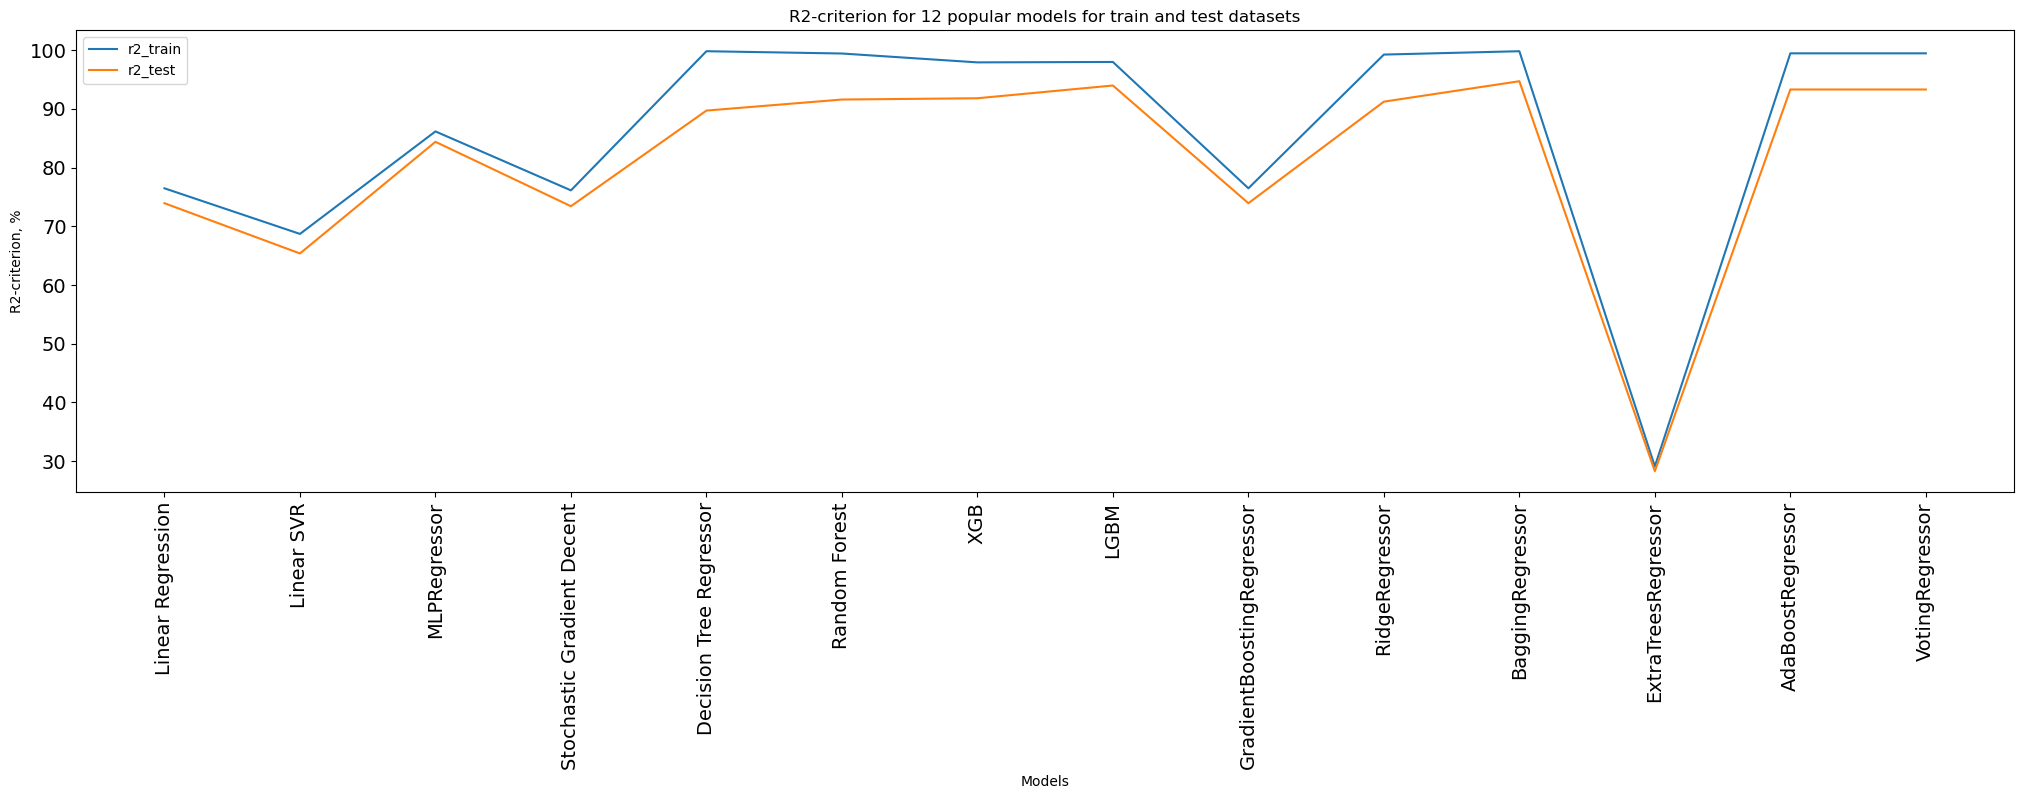

In [29]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 12 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

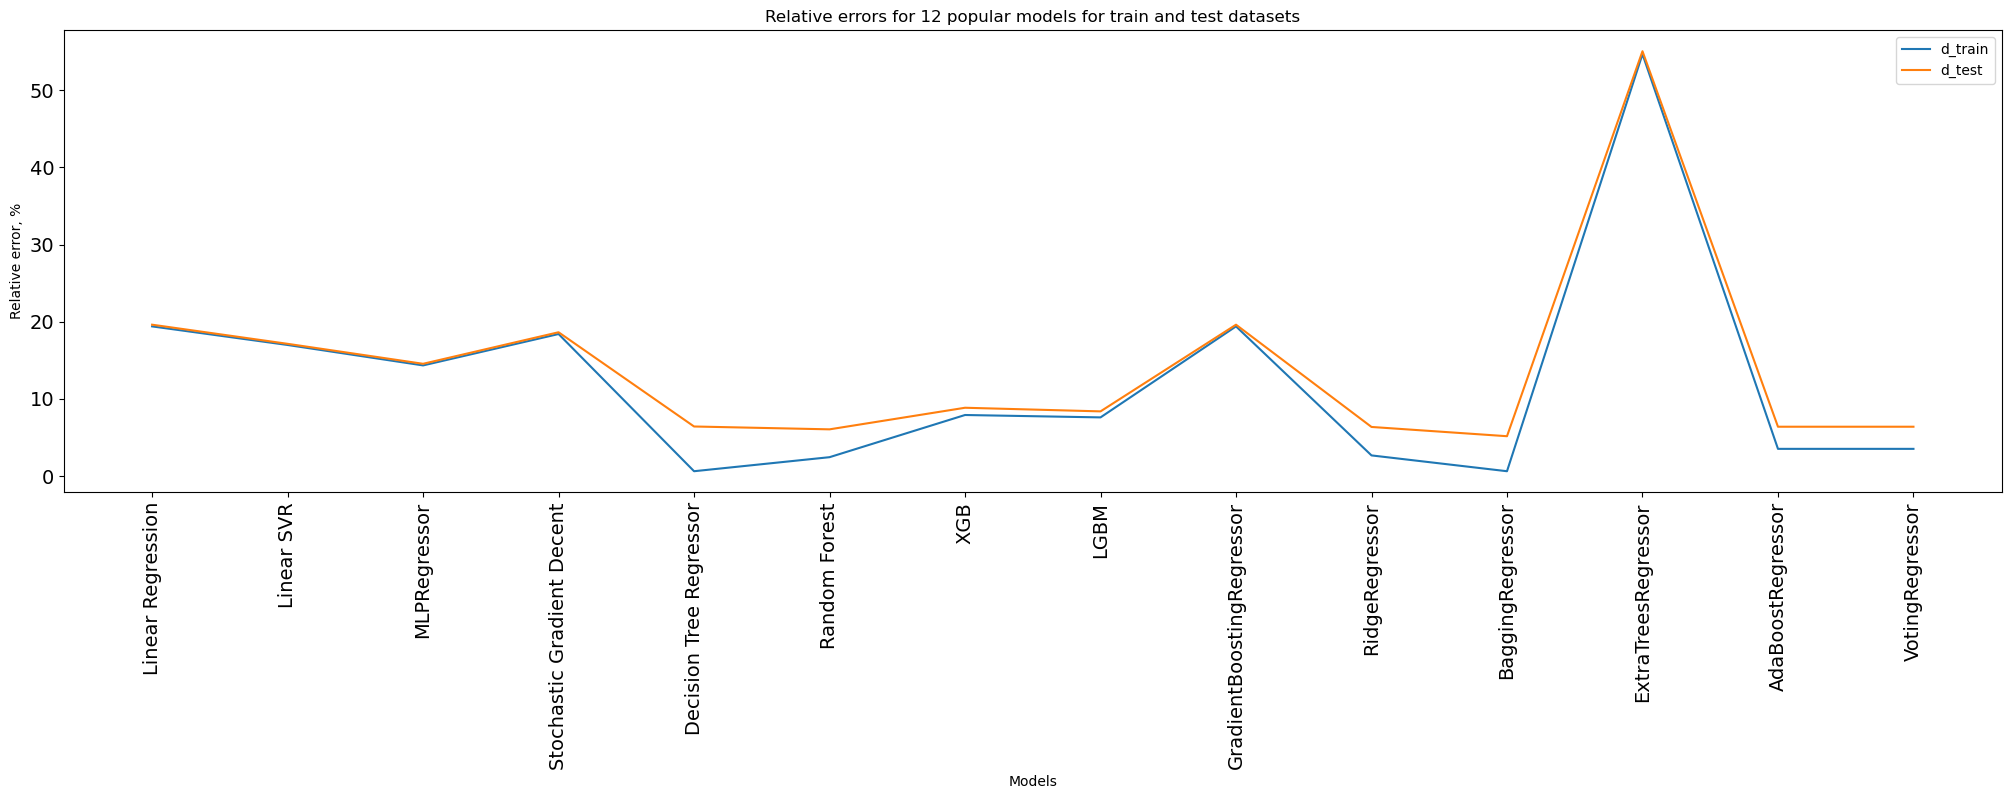

In [30]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 12 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

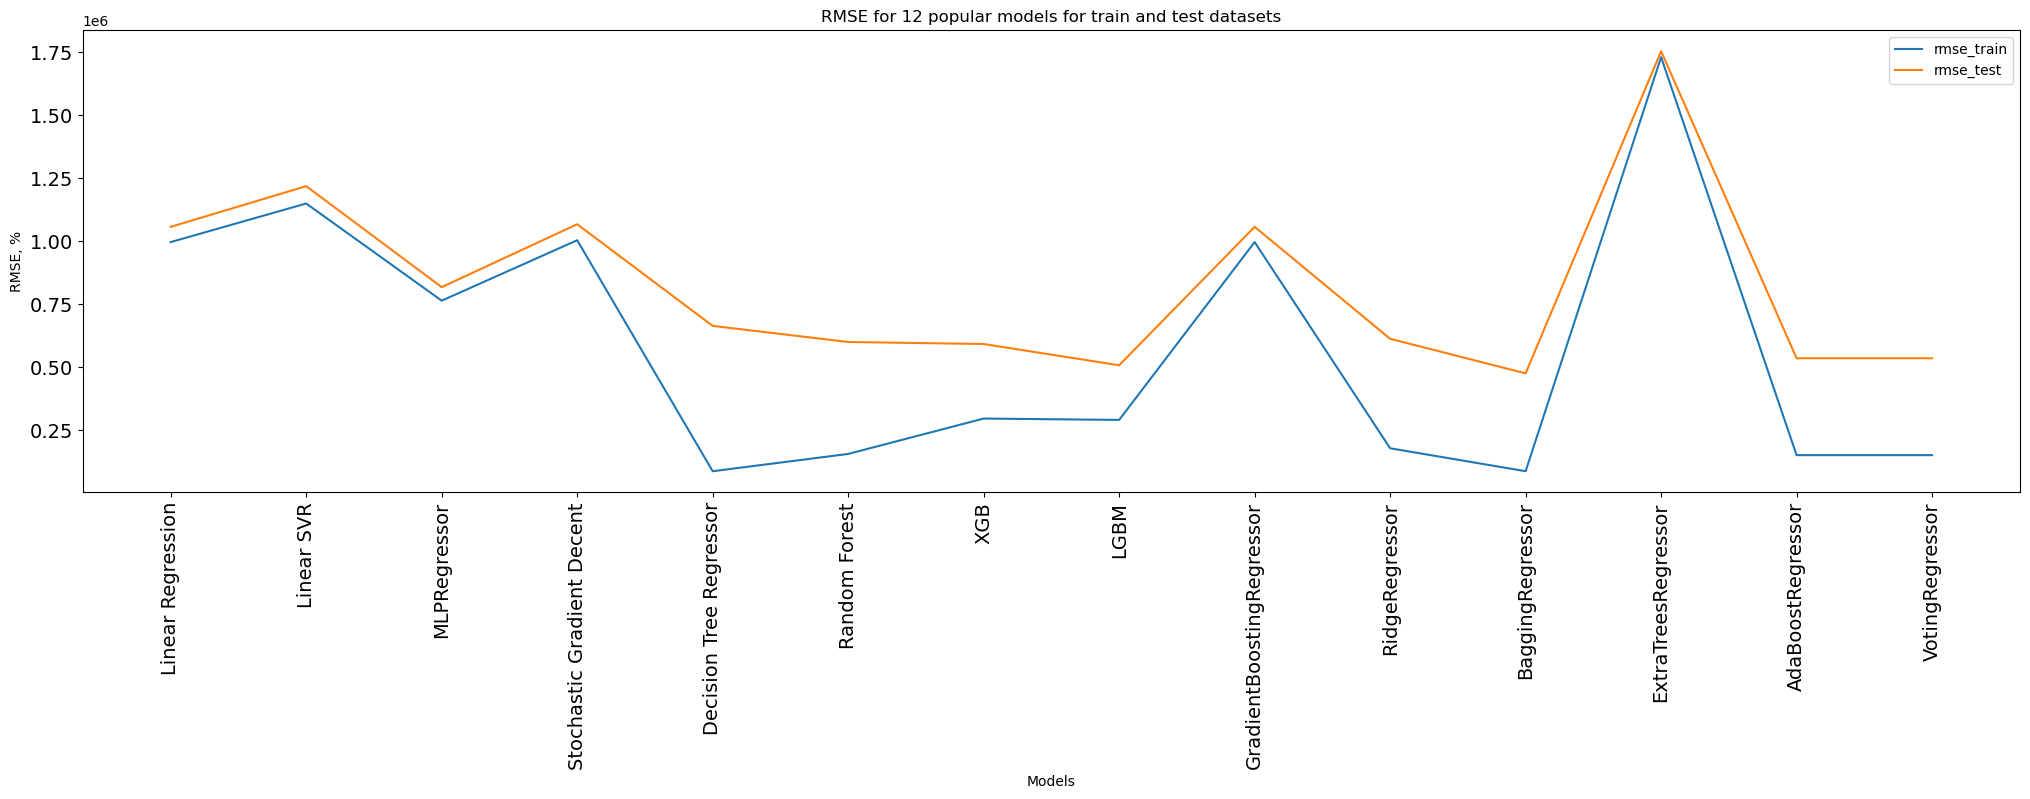

In [31]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 12 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

### Summary

To determine the best model from the provided table, we typically look for the highest evaluation metric values such as R-squared (r2) or the lowest root mean square error (RMSE) on the test dataset.

From the table you provided, it appears that the model with the highest R-squared value on the test dataset is the BaggingRegressor with an r2_test score of 94.70%. However, the Random Forest model also has a high R-squared value of 91.58%.

On the other hand, if we consider the RMSE values, the BaggingRegressor has the lowest RMSE on the test dataset (476,339.54), followed by the LGBM model (508,365.22).

Based on these metrics, we can conclude that the BaggingRegressor model performs the best overall, considering both R-squared and RMSE on the test dataset.